In [27]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.optim import SGD

In [28]:
data = pd.read_csv('diabetes_dataset.csv')
data.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [29]:
x = data.drop(['Outcome'], axis=1).values
n_inputs, n_features = x.shape

y = data['Outcome'].values.reshape(-1,1)

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=.8)
print(x_train.shape)
x_train, x_valid, y_train, y_valid = train_test_split(x,y,train_size=.8)
print(x_train.shape)

(1600, 8)
(1600, 8)


In [31]:
x_imputer = SimpleImputer()
x_train_imputed = x_imputer.fit_transform(x_train)
x_valid_imputed = x_imputer.transform(x_valid)
x_test_imputed = x_imputer.transform(x_test)

x_train_imputed.shape, x_valid_imputed.shape, x_test_imputed.shape

((1600, 8), (400, 8), (400, 8))

In [32]:
x_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train_imputed)
x_valid = x_scaler.transform(x_valid_imputed)
x_test = x_scaler.transform(x_test_imputed)

In [33]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

x_valid = torch.tensor(x_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [34]:
train_set = TensorDataset(x_train,y_train)
valid_set = TensorDataset(x_valid,y_valid)
test_set = TensorDataset(x_test, y_test)

In [35]:
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=10)
test_loader = DataLoader(test_set, batch_size=10)

In [36]:
model = nn.Sequential(
    nn.Linear(n_features, 1),
    # nn.Linear(10, 10),
    # nn.Linear(10, 10),
    # nn.Linear(10, 1),
    nn.Sigmoid()
)
model

Sequential(
  (0): Linear(in_features=8, out_features=1, bias=True)
  (1): Sigmoid()
)

In [37]:
loss_fn = nn.BCELoss()

In [38]:
optimizer = SGD(model.parameters(), lr=.02, momentum=.9)

In [39]:
n_epochs = 10
loss_train_hist, loss_valid_hist = [], []
acc_train_hist, acc_valid_hist = [], []


In [40]:
for epoch in range(n_epochs):


    mean_loss_train, mean_loss_valid = 0, 0
    mean_acc_train, mean_acc_valid = 0, 0 

    for x_batch, y_batch in train_loader:
        y_hat = model(x_batch)
        loss = loss_fn(y_hat,y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        mean_loss_train += loss.item() * len(x_batch)
        mean_acc_train += torch.sum(y_hat.round() == y_batch).item()
        # print( epoch ,mean_loss_train)

    with torch.no_grad():
        for x_batch, y_batch in valid_loader:
            y_hat = model(x_batch)
            loss = loss_fn(y_hat,y_batch)
            mean_loss_valid += loss.item() * len(x_batch)
            mean_acc_valid += torch.sum(y_hat.round() == y_batch).item()

            # print(mean_loss_valid)

    mean_loss_train = mean_loss_train/ len(train_set)
    mean_loss_valid = mean_loss_valid/ len(valid_set)

    mean_acc_train = mean_acc_train / len(train_set)
    mean_acc_valid = mean_acc_valid / len(valid_set)

    print(f"epoch:{epoch}, mean loss train: {mean_loss_train :.3}, mean loss valid:{mean_loss_valid :.3} mean acc train: {mean_acc_train}, mean acc valid {mean_acc_valid}")

    loss_train_hist.append(mean_loss_train)
    loss_valid_hist.append(mean_loss_valid)

    acc_train_hist.append(mean_acc_train)
    acc_valid_hist.append(mean_acc_valid)


epoch:0, mean loss train: 0.524, mean loss valid:0.484 mean acc train: 0.7375, mean acc valid 0.7825
epoch:1, mean loss train: 0.493, mean loss valid:0.477 mean acc train: 0.77, mean acc valid 0.785
epoch:2, mean loss train: 0.491, mean loss valid:0.478 mean acc train: 0.76875, mean acc valid 0.7925
epoch:3, mean loss train: 0.489, mean loss valid:0.477 mean acc train: 0.76625, mean acc valid 0.7875
epoch:4, mean loss train: 0.492, mean loss valid:0.477 mean acc train: 0.76875, mean acc valid 0.78
epoch:5, mean loss train: 0.491, mean loss valid:0.474 mean acc train: 0.77, mean acc valid 0.785
epoch:6, mean loss train: 0.488, mean loss valid:0.482 mean acc train: 0.76375, mean acc valid 0.775
epoch:7, mean loss train: 0.491, mean loss valid:0.478 mean acc train: 0.77, mean acc valid 0.7825
epoch:8, mean loss train: 0.49, mean loss valid:0.473 mean acc train: 0.765625, mean acc valid 0.7975
epoch:9, mean loss train: 0.489, mean loss valid:0.479 mean acc train: 0.76875, mean acc valid 0.

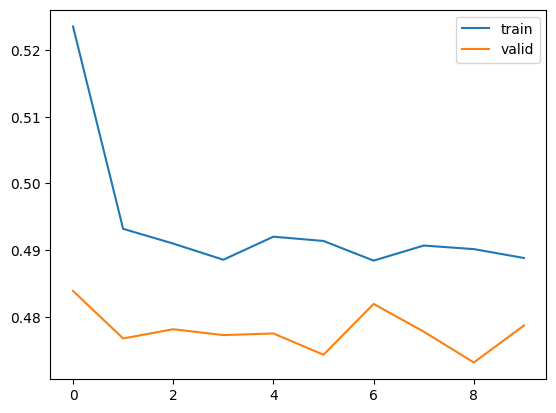

In [41]:
plt.plot(torch.arange(n_epochs) , loss_train_hist)
plt.plot(torch.arange(n_epochs) , loss_valid_hist )
plt.legend(['train', 'valid'])

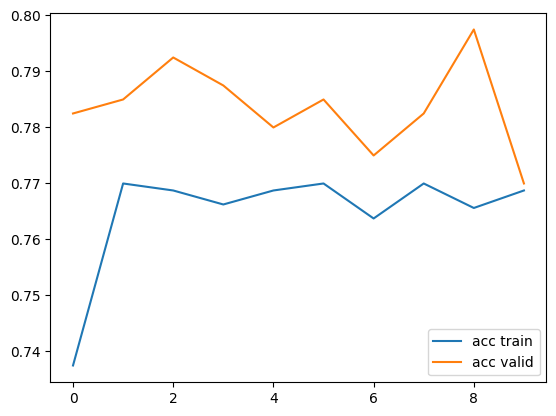

In [42]:
plt.plot(torch.arange(n_epochs), acc_train_hist)
plt.plot(torch.arange(n_epochs), acc_valid_hist)
plt.legend(['acc train', 'acc valid'])

In [43]:
mean_acc_test = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_hat = model(x_batch)
        mean_acc_test += torch.sum(y_hat.round() == y_batch).item()
    mean_acc_test = mean_acc_test/len(test_set)

print(f"mean acc test is : {mean_acc_test}")

mean acc test is : 0.775


Optuna Optimization
We'll optimize: Learning rate, Momentum, Number of hidden layers, Number of neurons per layer, Batch size, Number of epochs

In [44]:
import optuna
from optuna.trial import TrialState
from optuna.samplers import TPESampler

In [45]:
def define_model(trial, n_features):
    """Define the neural network model based on trial suggestions"""
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []
    in_features = n_features
    
    for i in range(n_layers):
        out_features = trial.suggest_int(f"n_units_layer_{i}", 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float(f"dropout_layer_{i}", 0.2, 0.5)
        layers.append(nn.Dropout(p))
        in_features = out_features
    
    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.Sigmoid())
    
    return nn.Sequential(*layers)

def objective(trial):
    """Objective function for Optuna to optimize"""
    # Hyperparameters to tune
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    momentum = trial.suggest_float("momentum", 0.1, 0.9)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])
    n_epochs = trial.suggest_int("n_epochs", 5, 30)
    
    # Create data loaders with suggested batch size
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size)
    
    # Create model
    model = define_model(trial, n_features)
    
    # Optimizer
    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_fn = nn.BCELoss()
    
    # Training loop
    for epoch in range(n_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        correct = 0
        with torch.no_grad():
            for x_batch, y_batch in valid_loader:
                y_pred = model(x_batch)
                correct += (y_pred.round() == y_batch).sum().item()
        
        accuracy = correct / len(valid_set)
        
        # Report intermediate objective value
        trial.report(accuracy, epoch)
        
        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return accuracy

# Optimize the study
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)
study.optimize(objective, n_trials=50, timeout=600)

# Print results
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"  Value (Accuracy): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train final model with best hyperparameters
best_params = trial.params
final_model = define_model(trial, n_features)
final_optimizer = SGD(
    final_model.parameters(),
    lr=best_params["lr"],
    momentum=best_params["momentum"]
)

# Training loop with best params
for epoch in range(best_params["n_epochs"]):
    final_model.train()
    for x_batch, y_batch in DataLoader(train_set, batch_size=best_params["batch_size"], shuffle=True):
        final_optimizer.zero_grad()
        y_pred = final_model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        final_optimizer.step()

# Evaluate on test set
final_model.eval()
test_correct = 0
with torch.no_grad():
    for x_batch, y_batch in DataLoader(test_set, batch_size=best_params["batch_size"]):
        y_pred = final_model(x_batch)
        test_correct += (y_pred.round() == y_batch).sum().item()

test_accuracy = test_correct / len(test_set)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")

[I 2025-05-21 16:17:57,167] A new study created in memory with name: no-name-898be7d8-9c25-43c1-a5f0-a20639fdf7e6
[I 2025-05-21 16:18:01,463] Trial 0 finished with value: 0.65 and parameters: {'lr': 0.0007229913879175868, 'momentum': 0.43141035165364794, 'batch_size': 16, 'n_epochs': 24, 'n_layers': 3, 'n_units_layer_0': 20, 'dropout_layer_0': 0.23664152500775137, 'n_units_layer_1': 114, 'dropout_layer_1': 0.3588529811942973, 'n_units_layer_2': 114, 'dropout_layer_2': 0.3255977182780522}. Best is trial 0 with value: 0.65.
[I 2025-05-21 16:18:06,805] Trial 1 finished with value: 0.805 and parameters: {'lr': 0.0014567032823998162, 'momentum': 0.7922023113854653, 'batch_size': 8, 'n_epochs': 29, 'n_layers': 3, 'n_units_layer_0': 23, 'dropout_layer_0': 0.42628538707134567, 'n_units_layer_1': 78, 'dropout_layer_1': 0.2412553790284322, 'n_units_layer_2': 27, 'dropout_layer_2': 0.4134393386260208}. Best is trial 1 with value: 0.805.
[I 2025-05-21 16:18:07,165] Trial 2 finished with value: 0.6

Number of finished trials:  50
Best trial:
  Value (Accuracy): 0.8175
  Params: 
    lr: 0.01006718202697164
    momentum: 0.8553004028015039
    batch_size: 8
    n_epochs: 16
    n_layers: 2
    n_units_layer_0: 56
    dropout_layer_0: 0.33311174598358784
    n_units_layer_1: 103
    dropout_layer_1: 0.44487667023785327

Final Test Accuracy: 0.8225


In [49]:
# Plot optimization history
optuna.visualization.plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 10, 11, 12, 13, 15, 17, 19, 20, 21, 22, 25, 26,
                    32, 33, 35, 39, 40, 43, 46, 47],
              'y': [0.65, 0.805, 0.6575, 0.7975, 0.4475, 0.65, 0.8025, 0.7925,
                    0.785, 0.8, 0.7875, 0.65, 0.8, 0.805, 0.7975, 0.805, 0.785,
                    0.8075, 0.78, 0.7875, 0.79, 0.8025, 0.7875, 0.8175, 0.7925]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
              'y': [0.65, 0.805, 0.805, 0.805, 0.805, 0.805, 0.805, 0.805, 0.805,
                    0.805, 0.805, 0.805, 0.805, 0.805, 0.805, 0.805, 0.805, 0.805,
                    0.805, 0.805, 0.805, 0.805, 0.805, 0.805, 0.805, 0.805, 0.805,
                    0.805, 0.805, 0.805, 0.805, 0.805, 0.8075, 0.8075, 0.8075,
                    0.8075, 0.8075, 0.8075, 0.8075, 0.8075, 0.8075, 0.8075, 0.8075,
                    0.8075, 0.8075, 0.8075, 0.8175, 0.8175, 0.8175, 0.8175]},
             {'marker': {'color': '#cccccc'},
              'mode': 'markers',
              'name': 'Infeasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'Objective Value'}}}
})

In [47]:
# Plot parameter importance
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [n_layers (IntDistribution):
                                0.0017192582231074203<extra></extra>, batch_size
                                (CategoricalDistribution):
                                0.0048523536132152965<extra></extra>, momentum
                                (FloatDistribution):
                                0.06869174450530523<extra></extra>, n_units_layer_0
                                (IntDistribution):
                                0.08790078177995019<extra></extra>, dropout_layer_0
                                (FloatDistribution):
                                0.11118205965331161<extra></extra>, lr
                                (FloatDistribution):
                                0.28190182560385546<extra></extra>, n_epochs
                                (IntDistribution):
                                0.4437519766212548<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, <0.01, 0.07, 0.09, 0.11, 0.28, 0.44],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.0017192582231074203, 0.0048523536132152965,
                    0.06869174450530523, 0.08790078177995019, 0.11118205965331161,
                    0.28190182560385546, 0.4437519766212548],
              'y': [n_layers, batch_size, momentum, n_units_layer_0,
                    dropout_layer_0, lr, n_epochs]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [48]:
# Plot slice of parameters
optuna.visualization.plot_slice(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': [0, 1, 2, 3, 4, 10, 11, 12, 13, 15, 17, 19, 20,
                                   21, 22, 25, 26, 32, 33, 35, 39, 40, 43, 46, 47],
                         'colorbar': {'title': {'text': 'Trial'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': True},
              'mode': 'markers',
              'name': 'Feasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [16, 8, 64, 32, 16, 8, 32, 8, 32, 32, 16, 8, 32, 32, 32, 8, 8,
                    16, 16, 16, 8, 8, 32, 8, 8],
              'xaxis': 'x',
              'y': [0.65, 0.805, 0.6575, 0.7975, 0.4475, 0.65, 0.8025, 0.7925,
                    0.785, 0.8, 0.7875, 0.65, 0.8, 0.805, 0.7975, 0.805, 0.785,
                    0.8075, 0.78, 0.7875, 0.79, 0.8025, 0.7875, 0.8175, 0.7925],
              'yaxis': 'y'},
             {'marker': {'color': [0, 1, 2, 3, 4, 10, 11, 12, 13, 15, 17, 19, 20,
                                   21, 22, 25, 26, 32, 33, 35, 39, 40, 43, 46, 47],
                         'colorbar': {'title': {'text': 'Trial'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': False},
              'mode': 'markers',
              'name': 'Feasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [0.23664152500775137, 0.42628538707134567, 0.4844822143632091,
                    0.4196498219665271, 0.3397151812288579, 0.4139165689541157,
                    0.4192620883121388, 0.4062849651593984, 0.3869107131895771,
                    0.37714335356376055, 0.44340109295701424, 0.2025805922890664,
                    0.48296197543088637, 0.37409461304125746, 0.42906705124889866,
                    0.3575468244404676, 0.3563359620098284, 0.39720521525602626,
                    0.40516827888528384, 0.45095207530017356, 0.27742899426693923,
                    0.375837949386222, 0.4377052206470104, 0.33311174598358784,
                    0.332559600613949],
              'xaxis': 'x2',
              'y': [0.65, 0.805, 0.6575, 0.7975, 0.4475, 0.65, 0.8025, 0.7925,
                    0.785, 0.8, 0.7875, 0.65, 0.8, 0.805, 0.7975, 0.805, 0.785,
                    0.8075, 0.78, 0.7875, 0.79, 0.8025, 0.7875, 0.8175, 0.7925],
              'yaxis': 'y2'},
             {'marker': {'color': [0, 1, 2, 3, 4, 10, 11, 13, 15, 17, 19, 20, 21,
                                   22, 32, 33, 35, 40, 43, 46, 47],
                         'colorbar': {'title': {'text': 'Trial'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb